# Obesity Estimation - Feature Engineering and Machine Learning Models

### In this notebook we will implement various Machine Learning Classification alogrithms to select the best performing model
1) Decision Tree </br>
2) Random Forest</br>
3) KNN </br>
4) XGBClassifier</br>


### We will use the following steps:
##### Split the Dataset:
Split the dataset into training and test sets before applying transformations to avoid data leakage.
##### One-Hot Encoding:
Apply one-hot encoding only to the training set using fit_transform.</br>
Use the same encoder to transform the test set with transform, ensuring consistency.</br>
Handle unknown categories with handle_unknown='ignore'.
##### Label Encoding for Target Variable:
Apply label encoding to the entire target column (train + test) for consistent label mappings across splits.
This is safe as it will not allow information to leak from features to the model.
##### Feature Scaling:
Apply scaling (e.g., StandardScaler or MinMaxScaler) only to the training set using fit_transform.
Use the same scaler to transform the test set with transform.
##### Save Encoders/Scalers:
Save the fitted encoders and scalers to ensure consistent transformations for future data.

#####  GridsearchCV and 5-fold cross-validation to compare the accuracies.

In [ ]:
import pandas as pd

In [ ]:
# Read data and convert to a dataframe
clean_data_df = pd.read_csv(r'../data/clean_data.csv')

clean_data_df.info()

In [ ]:
# Feature columns by preprocessing type: categorical and continous

cat_cols = ['Gender', 'Family_History', 'High_Cal_Foods_Frequently', 'Snacking','Smoke', 'Calorie_Monitoring', 'Freq_Alcohol', 'Transportation']

num_cols = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals','Water_Intake', 'Phys_Activity', 'Tech_Use']

### Define dataframes X and y 

In [ ]:
X = clean_data_df.drop('Obesity_Level',axis=1)  
y = clean_data_df['Obesity_Level'] 

X.shape, y.shape

### Train test split - stratified splitting
Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### One hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
# Encoding multiple columns. 
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), 
     cat_cols))

transformer

### X_train encoding

In [ ]:
# Transforming
transformed = transformer.fit_transform(X_train)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_train.index
# Joining tables
X_train = pd.concat([X_train, transformed_df], axis=1)
# Dropping old categorical columns
X_train.drop(cat_cols, axis=1, inplace=True)
# CHecking result
X_train.head()

### X_test encoding

In [ ]:
# Transforming
transformed = transformer.transform(X_test)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_test.index
# Joining tables
X_test = pd.concat([X_test, transformed_df], axis=1)
# Dropping old categorical columns
X_test.drop(cat_cols, axis=1, inplace=True)
# CHecking result
X_test.head()

In [ ]:
print(X_train.columns)

In [ ]:
# Setting new feature names

X_train.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']

X_test.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']
# After renaming the columns

X_train.head()


### Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
Standard_Scaler = StandardScaler()
x_scaled = Standard_Scaler.fit_transform(X_train[num_cols])
x_test_scaled = Standard_Scaler.transform(X_test[num_cols])

### Apply Label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

y_train

### Classifier Models 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [ ]:
models={'RandomForest':RandomForestClassifier(),
        'DecisionTree':DecisionTreeClassifier(),
        'KNeighbors':KNeighborsClassifier(),
        'xgbc': XGBClassifier()}

In [ ]:
param_grids={'RandomForest': {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20]},
            'DecisionTree': {
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            },'KNeighbors':{
            'n_neighbors': [3, 5, 7]
        }, 'xgbc':{
            'n_estimators':[600],
            'learning_rate':[0.03],
            'objective':['multi:softmax'], 
            'verbosity':[0], 
            'nthread':[-1], 
            'random_state':[42]
        }
    }

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')}
best_models = {}

for model in models:
    print(f"\nRunning GridSearch for {model}...")
    gsv = GridSearchCV(
        estimator=models[model],
        param_grid=param_grids[model],
        cv=5,
        scoring=scoring,
        refit='accuracy'  # Primary metric for model selection
    )
    gsv.fit(x_scaled, y_train_encoded)
    best_models[model] = gsv.best_estimator_
    best_index = gsv.best_index_
    print(f'Best parameters for {model}: {gsv.best_params_}')
    print(f'Best accuracy: {gsv.cv_results_["mean_test_accuracy"][best_index]:.4f}')
    print(f'Best precision: {gsv.cv_results_["mean_test_precision"][best_index]:.4f}')
    print(f'Best recall: {gsv.cv_results_["mean_test_recall"][best_index]:.4f}')

### Feature Importance

/var/folders/mx/wmp0fhkx7bv5my3zvkgnkwj80000gn/T/ipykernel_38360/2094430465.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')
/var/folders/mx/wmp0fhkx7bv5my3zvkgnkwj80000gn/T/ipykernel_38360/2094430465.py:16: UserWarning: 
The palette list has fewer values (4) than needed (31) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')


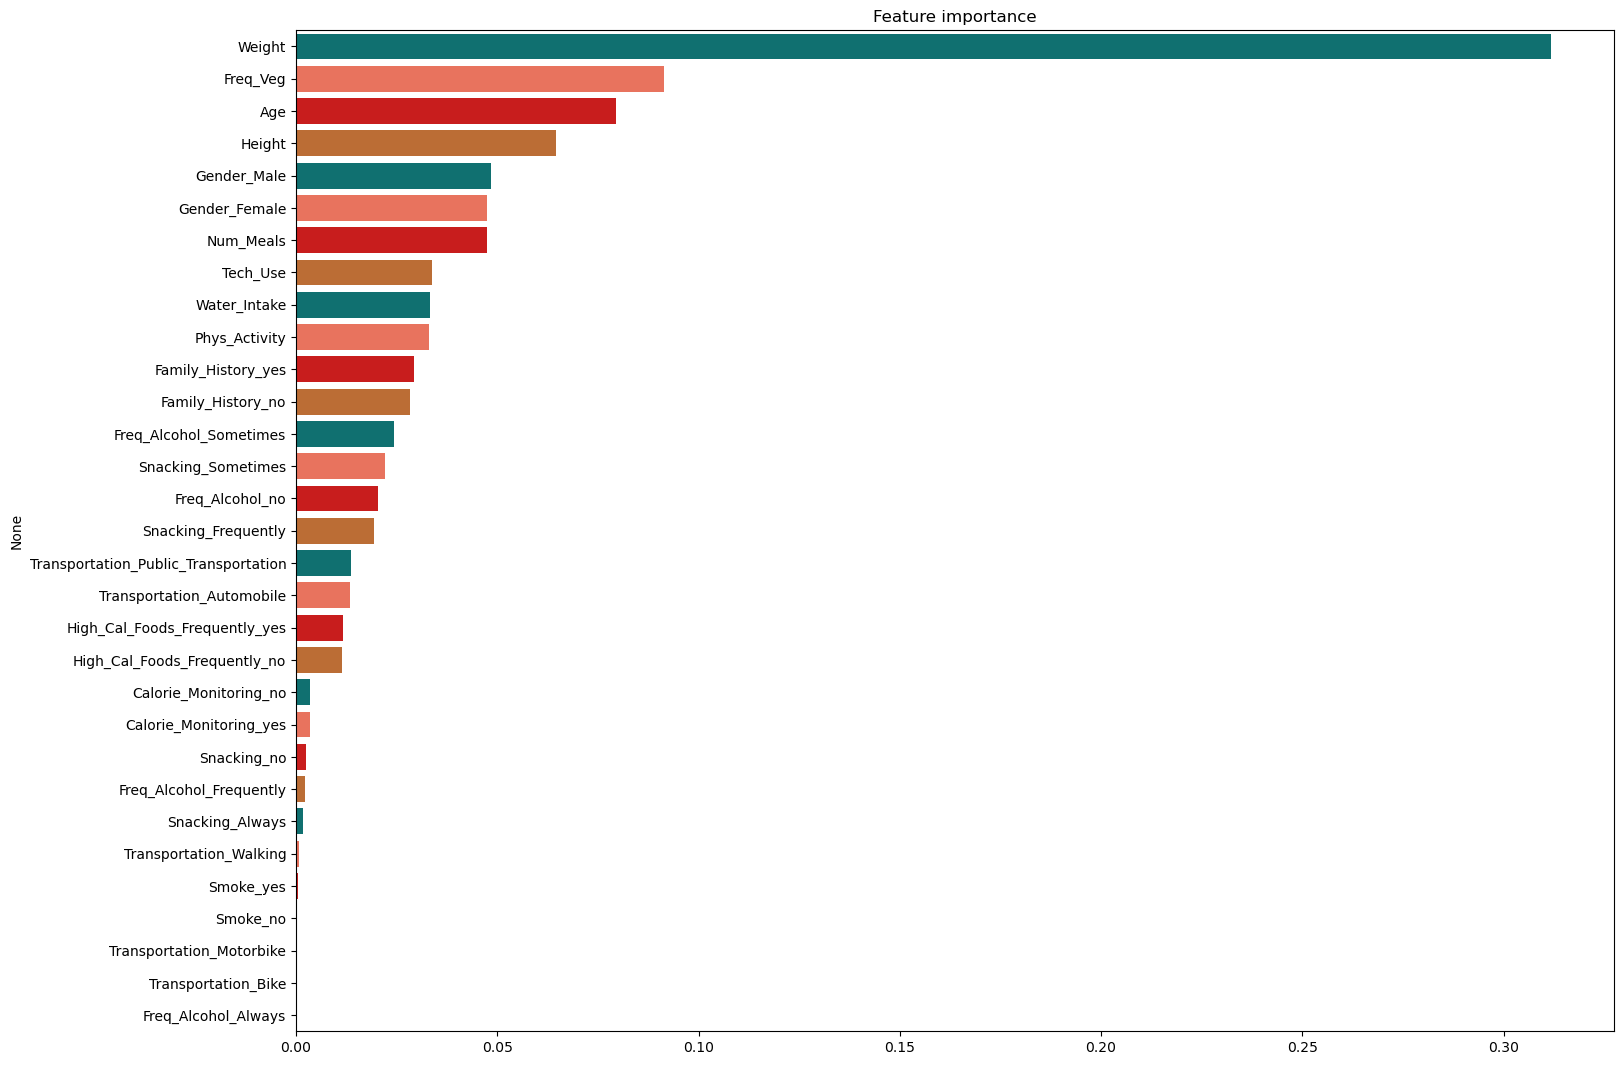

In [41]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

palette = ['#008080','#FF6347', '#E50000', '#D2691E'] # Creating color palette for plots

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(X_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')